[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/facebookresearch/esm/blob/master/examples/variant_prediction.ipynb)

# Variant prediction with ESM

This tutorial demonstrates how to train a simple variant predictor, i.e. we predict the biological activity of mutations of a protein, using fixed embeddings from ESM. You can adopt a similar protocol to train a model for any downstream task, even with limited data.

We will use a simple classifier in sklearn (or "head" on top of the transformer features) to predict the mutation effect from precomputed ESM embeddings. The embeddings for your dataset can be dumped once using a GPU. Then, the rest of your analysis can be done on CPU. 

### Background

In this particular example, we will train a model to predict the activity of ß-lactamase variants.

We provide the training in `examples/P62593.fasta`, a FASTA file where each entry contains:
- the mutated ß-lactamase sequence, where a single residue is mutated (swapped with another amino acid)
- the target value in the last field of the header, describing the scaled effect of the mutation

The [data originally comes](https://github.com/FowlerLab/Envision2017/blob/master/data/dmsTraining_2017-02-20.csv) from a deep mutational scan and was released with the Envision paper (Gray, et al. 2018)

### Goals
- Obtain an embedding (fixed-dimensional vector representation) for each mutated sequence.
- Train a regression model in sklearn that can predict the "effect" score given the embedding.


### Prerequisites
- You will need the following modules : tqdm, matplotlib, numpy, pandas, seaborn, scipy, scikit-learn
- You have obtained sequence embeddings for ß-lactamase as described in the README, either by:
    - running `python extract.py esm1_t34_670M_UR50S examples/P62593.fasta examples/P62593_reprs/ --repr_layers 34 --include mean`  OR 
    - for your convenience we precomputed the embeddings and you can download them from [here](https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz) - see below to download this right here from in this notebook


In [ ]:
!pip install git+https://github.com/facebookresearch/esm.git
#!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
#!tar -xzf P62593_reprs.tar.gz
#!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
#!pwd
#!ls

  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-4wksmwa_
  Running command git clone -q https://github.com/facebookresearch/esm.git /tmp/pip-req-build-4wksmwa_
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for fair-esm: filename=fair_esm-0.4.0-py3-none-any.whl size=38563 sha256=555b258095ec85983aca587771a4af9a3bf0fd7920c1bb0d8450863e908709d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-t7euq8i0/wheels/5c/8e/11/307eca5379b418a9989ef4d24ead655755f2500a577ec95208
Successfully built fair-esm


As an alternative to pip installing, you can just put the repo on your python path:

In [ ]:
# import sys
# PATH_TO_REPO = "../"
# sys.path.append(PATH_TO_REPO)

In [ ]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import esm

In [ ]:
import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd Mnp
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Mnp
/content/drive/My Drive/Mnp


In [ ]:
FASTA_PATH = "./Mnp_3m5q.fasta" # Path to P62593.fasta
EMB_PATH = "./Mnp_3m5q_reprs" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 34

In [ ]:
ys = []
Xs = []
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('-')[-1]
    ys.append(float(scaled_effect))
    fn = f'{EMB_PATH}/{header[1:]}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])
Xs = torch.stack(Xs, dim=0).numpy()
print(len(ys))
print(Xs.shape)

151
(151, 1280)


In [ ]:
train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

In [ ]:
Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

((120, 1280), (31, 1280), 120, 31)

In [ ]:
pca = PCA(68)
Xs_train_pca = pca.fit_transform(Xs_train)

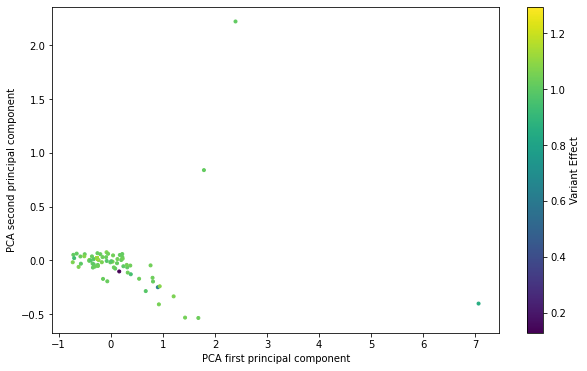

In [ ]:
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')
plt.savefig('final.png')

In [ ]:
knn_grid = {
    'n_neighbors': [5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [15, 30],
    'p' : [1, 2],
}

svm_grid = {
    'C' : [0.1, 1.0, 10.0],
    'kernel' :['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [3],
    'gamma': ['scale'],
}

rfr_grid = {
    'n_estimators' : [20],
    'criterion' : ['mse', 'mae'],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split' : [5, 10],
    'min_samples_leaf': [1, 4]
}

In [ ]:
cls_list = [KNeighborsRegressor, SVR, RandomForestRegressor]
param_grid_list = [knn_grid, svm_grid, rfr_grid]

In [ ]:
result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = cls_name(), 
        param_grid = param_grid,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs_train_pca, ys_train)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished


<class 'sklearn.svm._classes.SVR'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.5s finished


### K Nearest Neighbors

In [ ]:
result_list[0].sort_values('rank_test_score')[:5]

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
47       0.002036      0.002069  ...        0.125885                1
39       0.000622      0.000033  ...        0.125885                1
38       0.000590      0.000047  ...        0.117609                3
46       0.000728      0.000253  ...        0.117609                3
19       0.001156      0.000013  ...        0.142474                5

[5 rows x 18 columns]

### SVM

In [ ]:
result_list[1].sort_values('rank_test_score')

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
6        0.001258      0.000110  ...        0.117513                1
2        0.001265      0.000079  ...        0.093598                2
10       0.001234      0.000192  ...        0.140816                3
0        0.001561      0.000232  ...        0.092204                4
4        0.003137      0.002829  ...        0.369721                5
1        0.001390      0.000177  ...        0.944167                6
3        0.001893      0.000168  ...        1.911884                7
8        0.002147      0.000236  ...        3.565700                8
7        0.002099      0.000086  ...      277.180306                9
5        0.003337      0.002544  ...     2751.269909               10
9        0.004252      0.003986  ...    12785.603616               11
11       0.002353      0.000305  ...    27058.495593               12

[12 rows x 17 columns]

### Random Forest

In [ ]:
result_list[2].sort_values('rank_test_score')[:5]

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
7        0.045960      0.001259  ...        0.138945                1
3        0.047440      0.001005  ...        0.150153                2
4        0.048218      0.002222  ...        0.115327                3
15       0.051975      0.005063  ...        0.143534                4
6        0.047643      0.004797  ...        0.133527                5

[5 rows x 18 columns]

<a id='eval'></a>
## Evaluation

Now that we have run grid search, each `grid` object contains a `best_estimator_`.

We can use this to evaluate the correlation between our predictions and the true effect scores on the held-out validation set.

In [ ]:
Xs_test_pca = pca.transform(Xs_test)
for grid in grid_list:
    print(grid.best_estimator_)
    print()
    preds = grid.predict(Xs_test_pca)
    print(f'{scipy.stats.spearmanr(ys_test, preds)}')
    print('\n', '-' * 80, '\n')


KNeighborsRegressor(algorithm='brute', leaf_size=15, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='distance')

SpearmanrResult(correlation=0.5421846359681668, pvalue=0.001628622123339105)

 -------------------------------------------------------------------------------- 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SpearmanrResult(correlation=0.548044999159772, pvalue=0.0014147307740052272)

 -------------------------------------------------------------------------------- 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight

The SVM performs the best on the `test` set, with a spearman rho of 0.80! 

This is in line with our grid-search results, where it also had the best `validation` performance.

In conclusion, our downstream model was able to use fixed pre-trained ESM embedding representations and obtain a decent result.

(For reference, we report correlation of 0.89 in Table 7 of [the paper](https://www.biorxiv.org/content/10.1101/622803v3), but this was achieved by fine-tuning the model)